

1.   Sree Charan Reddy Gangireddy
2.   862327313
3.   sgang011@ucr.edu



In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
#Imports
import torch
import math
import torch.nn as nn
import torchvision
from torchvision import transforms
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [3]:
#Normalize Tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

#Load the CIFAR10 Dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:03<00:00, 47722827.05it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# Print all 10 classes
classes = train_dataset.classes
print("Classes:", classes)

Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [5]:
#Shape of datasets data
def dataShape(dataset):
    test_data = dataset.data
    print("Datasets data shape:", test_data.shape)

In [6]:
dataShape(test_dataset)
dataShape(train_dataset)

Datasets data shape: (10000, 32, 32, 3)
Datasets data shape: (50000, 32, 32, 3)


In [7]:
def PrintImages(train_dataset):
    # Create a dictionary to store one image per class
    class_images = {}

    # Iterate over the dataset and select one image from each class
    for i in range(len(train_dataset)):
        image, label = train_dataset[i]
        class_name = classes[label]

        # If the class image is not already stored, add it to the dictionary
        if class_name not in class_images:
            class_images[class_name] = image
            if len(class_images) == len(classes):
                break

    # Plot one image from each class using Matplotlib
    fig, axs = plt.subplots(2, 5, figsize=(12, 6))
    fig.tight_layout()

    for i, class_name in enumerate(class_images.keys()):
        image = class_images[class_name]
        row = i // 5
        col = i % 5
        axs[row, col].imshow(image.permute(1, 2, 0))
        axs[row, col].set_title(class_name)
        axs[row, col].axis('off')

    plt.show()

In [8]:
# Create a Subset of the training dataset with 1,000 examples per class
subset_indices = []
for class_label in range(10):
    class_indices = torch.where(torch.tensor(train_dataset.targets) == class_label)[0]
    class_subset_indices = class_indices[:1000]
    subset_indices.extend(class_subset_indices.tolist())

subset_train_dataset = torch.utils.data.Subset(train_dataset, subset_indices)
# subset_train_dataset = torch.utils.data.dataset.Subset(train_dataset, subset_indices)

In [9]:
#Print Subset data:
def subShape(dataset):
  # Access an example from the subset_train_dataset
  example_data, example_label = dataset[0]
  # Check the shape of the example data
  print("Example data shape:", example_data.shape)

In [10]:
dataShape(train_dataset)
# dataShape(subset_train_dataset)
subShape(subset_train_dataset)
# print(" data shape:", subset_train_dataset[0][0].shape)
print("Subset train dataset shape:", subset_train_dataset.dataset.data.shape)

Datasets data shape: (50000, 32, 32, 3)
Example data shape: torch.Size([3, 32, 32])
Subset train dataset shape: (50000, 32, 32, 3)


In [11]:
#Verification
class_counts = {}

# Count the number of samples for each class in the subset dataset
for _, label in subset_train_dataset:
    class_counts[label] = class_counts.get(label, 0) + 1

# Verify if there are 1000 samples in each class
for class_label in range(10):
    count = class_counts.get(class_label, 0)
    print(f"Class {class_label}: {count} samples")

Class 0: 1000 samples
Class 1: 1000 samples
Class 2: 1000 samples
Class 3: 1000 samples
Class 4: 1000 samples
Class 5: 1000 samples
Class 6: 1000 samples
Class 7: 1000 samples
Class 8: 1000 samples
Class 9: 1000 samples


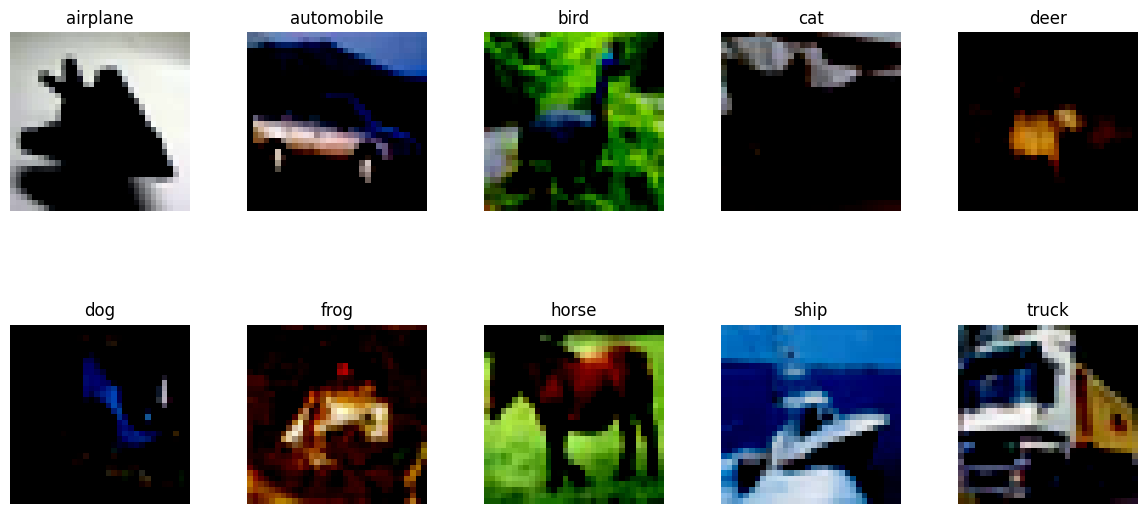

In [12]:
PrintImages(subset_train_dataset)

In [13]:
# Define the ResNet20 model
class ResNet20(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet20, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x) + x
        x = self.layer2(x) 
        x = self.layer3(x) 
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

#Function to calculate accuracy
def accuracy(outputs, targets):
    _, predicted = torch.max(outputs, dim=1)
    correct = (predicted == targets).sum().item()
    return correct / targets.size(0)


In [14]:
def ModelRun(train_loader, test_loader, mixup, alpha):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #Define the model, loss function, and optimizer
    model = ResNet20(num_classes=10).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4) #Adam Optimizer
    train_data = []
    test_data = []
    loss_data = []

    #Training loop
    total_step = len(train_loader)
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_acc = 0.0
          
        for i, (images, labels) in enumerate(train_loader):
            
            #Minibatch for Mixup
            if mixup:
              #Convert labels to one-hot encoding
              labels_one_hot = F.one_hot(labels, 10)
              images, labels = mixup_data(images, labels_one_hot, alpha)

            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)
            #Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            #Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            if mixup:
                   _, labels = torch.max(labels, dim=1)  #Convert one-hot encoded targets back to indices        
            train_acc += accuracy(outputs, labels)
        
        loss_data.append(train_loss / total_step)
        train_data.append((train_acc / total_step) * 100)

        #training loss and accuracy for each epoch
        model.eval()
        test_acc = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                if mixup:
                  #Convert labels to one-hot encoding
                  labels_one_hot = F.one_hot(labels, 10)
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                test_acc += accuracy(outputs, labels)
            test_data.append((test_acc / len(test_loader)) * 100)    
        
        #Print loss and accuracy
        print('Epoch [{}/{}], Loss: {:.4f}, Train Accuracy: {:.2f}%, Test Accuracy: {:.2f}%'
              .format(epoch + 1, epochs, train_loss / total_step, (train_acc / total_step) * 100, (test_acc / len(test_loader)) * 100))
    
    #Plotting
    y = train_data
    z = test_data
    x = loss_data

    fig, axs = plt.subplots(3,1)

    #Train vs Iterations plot:
    axs[0].plot(y)
    axs[0].set_title(f"Train Accuracy vs Iters")

    #Test vs Iterations plot:
    axs[1].plot(z)
    axs[1].set_title(f'Test Accuracy vs Iters')

    #Loss vs Iteration:
    axs[2].plot(x)
    axs[2].set_title(f'Loss vs Iters')

    # plt.subplots_adjust(wspace=0.4)
    plt.tight_layout()

    plt.show()

# 1st Question

Epoch [1/100], Loss: 1.7135, Train Accuracy: 35.75%, Test Accuracy: 41.75%
Epoch [2/100], Loss: 1.4523, Train Accuracy: 47.10%, Test Accuracy: 45.84%
Epoch [3/100], Loss: 1.2880, Train Accuracy: 53.84%, Test Accuracy: 49.64%
Epoch [4/100], Loss: 1.1853, Train Accuracy: 57.60%, Test Accuracy: 58.82%
Epoch [5/100], Loss: 1.1165, Train Accuracy: 60.34%, Test Accuracy: 56.30%
Epoch [6/100], Loss: 1.0603, Train Accuracy: 62.01%, Test Accuracy: 58.28%
Epoch [7/100], Loss: 1.0104, Train Accuracy: 63.98%, Test Accuracy: 58.96%
Epoch [8/100], Loss: 0.9670, Train Accuracy: 65.62%, Test Accuracy: 59.74%
Epoch [9/100], Loss: 0.9169, Train Accuracy: 67.39%, Test Accuracy: 60.72%
Epoch [10/100], Loss: 0.8804, Train Accuracy: 69.03%, Test Accuracy: 60.82%
Epoch [11/100], Loss: 0.8338, Train Accuracy: 70.32%, Test Accuracy: 59.33%
Epoch [12/100], Loss: 0.8007, Train Accuracy: 71.88%, Test Accuracy: 61.29%
Epoch [13/100], Loss: 0.7732, Train Accuracy: 72.23%, Test Accuracy: 63.58%
Epoch [14/100], Loss:

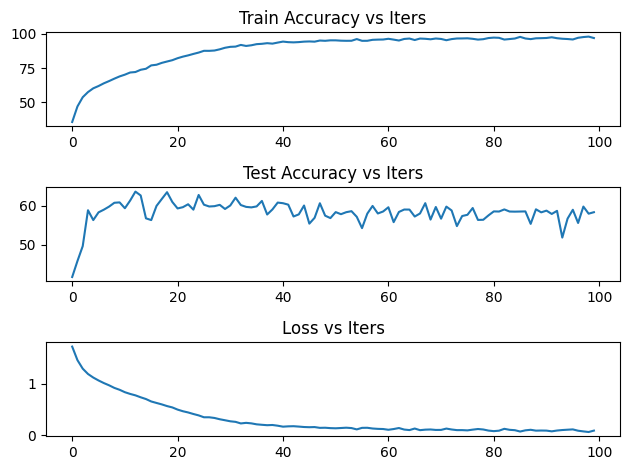

In [15]:
#Run RESNET20 without Augmentation
batch_size = 32
epochs = 100
learning_rate = 0.001

#Data Loaders
train_loader = torch.utils.data.DataLoader(subset_train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

ModelRun(train_loader, test_loader,mixup=False, alpha=0)

# 2nd Question

In [16]:
#MIXUP
import torch.distributions.beta as beta

# Function for mixup augmentation
def mixup_data(x, y, alpha):
    batch_size = x.size(0)
    lambd = beta.Beta(alpha, alpha).sample((batch_size,)).to(x.device)
    lambd = torch.max(lambd, 1 - lambd)  # Ensure lambda >= 0.5
    lambd = lambd.view(batch_size, 1, 1, 1)

    shuffled_indices = torch.randperm(batch_size).to(x.device)

    mixed_x = lambd * x + (1 - lambd) * x[shuffled_indices]
    lambd = lambd.expand(-1, y.size(1), -1, -1) # Expand lambd dimensions to match y(one hot encoding)
    # print(lambd.shape)
    mixed_y = lambd.squeeze() * y + (1 - lambd.squeeze()) * y[shuffled_indices]
    
    return mixed_x, mixed_y

def mixup_dataset(train_loader,mixup_alpha):
  image_list = []
  label_list = []

  for i, (images, labels) in enumerate(train_loader):
          # Apply mixup augmentation
          images, labels = mixup_data(images, labels, mixup_alpha)
          image_list.append(images)
          label_list.append(labels)

  all_images_tensor = torch.cat(image_list, dim=0)        
  label_list_tensor = torch.cat(label_list, dim=0)
  # Create a new dataset using the augmented data
  augmented_dataset = torch.utils.data.TensorDataset(all_images_tensor, label_list_tensor)

  return augmented_dataset

In [17]:
# Define the training parameters
batch_size = 32
epochs = 100
learning_rate = 0.001

#Data Loaders
train_loader = torch.utils.data.DataLoader(subset_train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Epoch [1/100], Loss: 1.8332, Train Accuracy: 34.90%, Test Accuracy: 36.17%
Epoch [2/100], Loss: 1.5960, Train Accuracy: 45.97%, Test Accuracy: 44.83%
Epoch [3/100], Loss: 1.4795, Train Accuracy: 51.70%, Test Accuracy: 54.16%
Epoch [4/100], Loss: 1.4009, Train Accuracy: 55.11%, Test Accuracy: 45.81%
Epoch [5/100], Loss: 1.3502, Train Accuracy: 57.37%, Test Accuracy: 54.01%
Epoch [6/100], Loss: 1.3174, Train Accuracy: 58.30%, Test Accuracy: 52.24%
Epoch [7/100], Loss: 1.2806, Train Accuracy: 60.46%, Test Accuracy: 54.85%
Epoch [8/100], Loss: 1.2426, Train Accuracy: 62.36%, Test Accuracy: 60.86%
Epoch [9/100], Loss: 1.2365, Train Accuracy: 62.57%, Test Accuracy: 58.49%
Epoch [10/100], Loss: 1.1968, Train Accuracy: 64.48%, Test Accuracy: 61.15%
Epoch [11/100], Loss: 1.1817, Train Accuracy: 65.33%, Test Accuracy: 63.03%
Epoch [12/100], Loss: 1.1494, Train Accuracy: 66.94%, Test Accuracy: 62.58%
Epoch [13/100], Loss: 1.1360, Train Accuracy: 67.23%, Test Accuracy: 60.59%
Epoch [14/100], Loss:

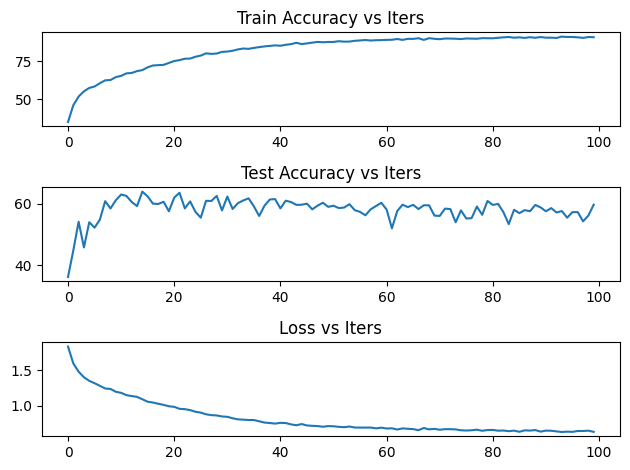

In [19]:
# For alpha = 0.2
ModelRun(train_loader, test_loader, mixup=True, alpha=0.2)

Epoch [1/100], Loss: 1.9233, Train Accuracy: 32.27%, Test Accuracy: 37.63%
Epoch [2/100], Loss: 1.7338, Train Accuracy: 41.98%, Test Accuracy: 47.14%
Epoch [3/100], Loss: 1.6287, Train Accuracy: 47.95%, Test Accuracy: 50.57%
Epoch [4/100], Loss: 1.5546, Train Accuracy: 51.94%, Test Accuracy: 52.52%
Epoch [5/100], Loss: 1.5165, Train Accuracy: 53.71%, Test Accuracy: 51.90%
Epoch [6/100], Loss: 1.4535, Train Accuracy: 56.26%, Test Accuracy: 57.14%
Epoch [7/100], Loss: 1.4280, Train Accuracy: 57.79%, Test Accuracy: 58.31%
Epoch [8/100], Loss: 1.4109, Train Accuracy: 59.32%, Test Accuracy: 53.21%
Epoch [9/100], Loss: 1.3760, Train Accuracy: 60.32%, Test Accuracy: 58.95%
Epoch [10/100], Loss: 1.3568, Train Accuracy: 61.27%, Test Accuracy: 58.05%
Epoch [11/100], Loss: 1.3290, Train Accuracy: 62.33%, Test Accuracy: 60.96%
Epoch [12/100], Loss: 1.3215, Train Accuracy: 63.57%, Test Accuracy: 60.04%
Epoch [13/100], Loss: 1.2930, Train Accuracy: 64.90%, Test Accuracy: 60.24%
Epoch [14/100], Loss:

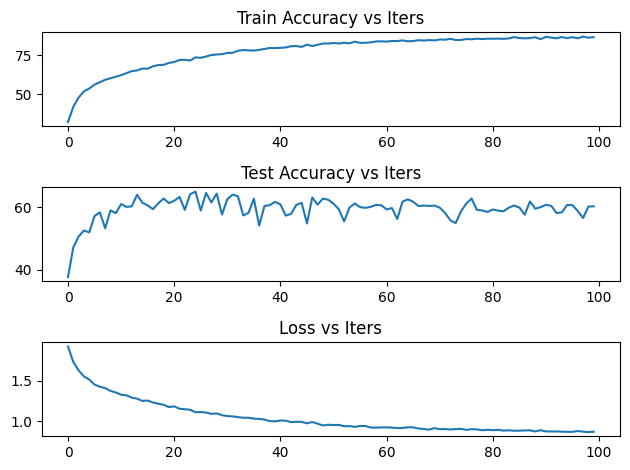

In [21]:
#For alpha = 0.4
ModelRun(train_loader, test_loader, mixup=True, alpha=0.4)

# 3rd Question

In [22]:
#Cut Out
import random
import torch

# Define the training parameters
batch_size = 32
epochs = 100
learning_rate = 0.001
cutout_prob = 0.5  # Probability of applying cutout
cutout_size = 16  # Size of the cutout mask

# Data Loaders
train_loader = torch.utils.data.DataLoader(subset_train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the cutout function
def cutout(image, label, size):
    height, width = image.shape[1], image.shape[2]
    mask = torch.ones_like(image)
    
    if random.random() < cutout_prob:
        x = random.randint(0, width - 1)
        y = random.randint(0, height - 1)
        
        x1 = max(0, x - size // 2)
        x2 = min(width, x + size // 2)
        y1 = max(0, y - size // 2)
        y2 = min(height, y + size // 2)
        
        mask[:, y1:y2, x1:x2] = 0
        
    image = image * mask
    return image, label


def CutOff_dataset(train_loader):
  image_list = []
  label_list = []

  for images, labels in train_loader:
        images = images.clone()
        
        for i in range(len(images)):
            images[i], labels[i] = cutout(images[i], labels[i], cutout_size)
        image_list.append(images)
        label_list.append(labels)

  all_images_tensor = torch.cat(image_list, dim=0)        
  label_list_tensor = torch.cat(label_list, dim=0)
  # Create a new dataset using the augmented data
  augmented_dataset = torch.utils.data.TensorDataset(all_images_tensor, label_list_tensor)

  return augmented_dataset

augmented_CutOff_dataset = CutOff_dataset(train_loader)

# Create the train loader with mixup augmented data
train_loader_CutOff= torch.utils.data.DataLoader(augmented_CutOff_dataset, batch_size=batch_size, shuffle=True)


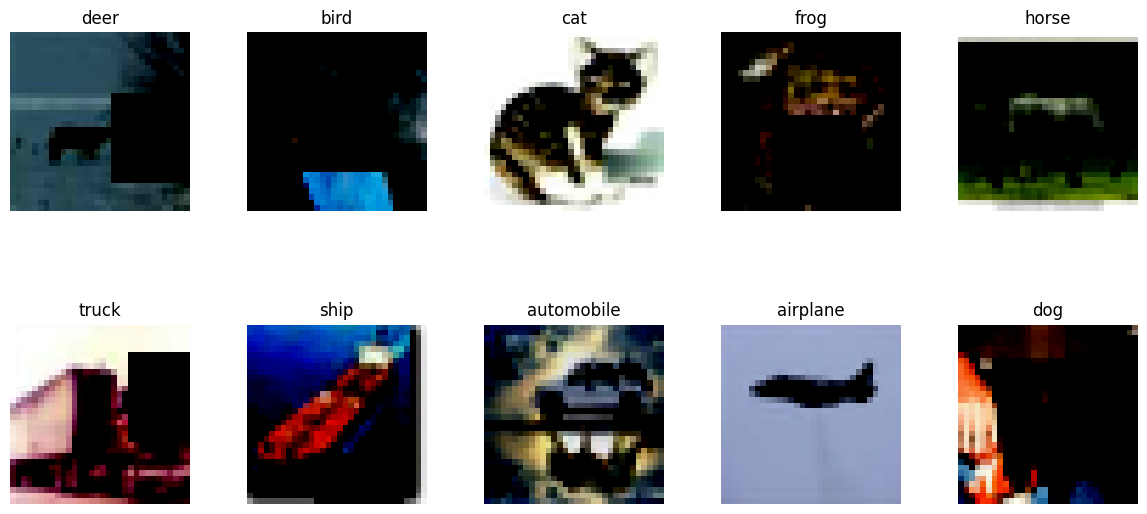

In [23]:
PrintImages(augmented_CutOff_dataset)

Epoch [1/100], Loss: 1.7418, Train Accuracy: 35.12%, Test Accuracy: 32.64%
Epoch [2/100], Loss: 1.5010, Train Accuracy: 45.31%, Test Accuracy: 46.15%
Epoch [3/100], Loss: 1.3612, Train Accuracy: 52.11%, Test Accuracy: 51.14%
Epoch [4/100], Loss: 1.2723, Train Accuracy: 54.69%, Test Accuracy: 51.53%
Epoch [5/100], Loss: 1.2030, Train Accuracy: 56.87%, Test Accuracy: 54.01%
Epoch [6/100], Loss: 1.1391, Train Accuracy: 59.22%, Test Accuracy: 55.30%
Epoch [7/100], Loss: 1.0934, Train Accuracy: 61.00%, Test Accuracy: 57.31%
Epoch [8/100], Loss: 1.0677, Train Accuracy: 61.46%, Test Accuracy: 58.70%
Epoch [9/100], Loss: 1.0166, Train Accuracy: 63.74%, Test Accuracy: 56.18%
Epoch [10/100], Loss: 0.9778, Train Accuracy: 64.79%, Test Accuracy: 57.20%
Epoch [11/100], Loss: 0.9516, Train Accuracy: 65.36%, Test Accuracy: 58.67%
Epoch [12/100], Loss: 0.9081, Train Accuracy: 67.93%, Test Accuracy: 58.29%
Epoch [13/100], Loss: 0.8902, Train Accuracy: 68.82%, Test Accuracy: 59.03%
Epoch [14/100], Loss:

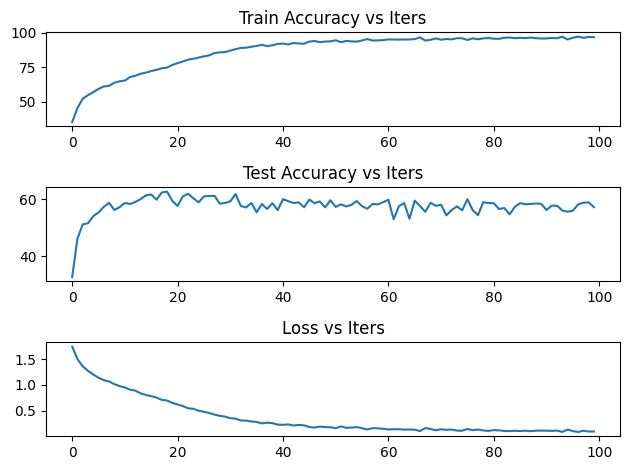

In [24]:
ModelRun(train_loader_CutOff, test_loader,mixup=False, alpha=0)

# 4th Question

In [25]:
#Standard Augmentaiton
import torch
import torchvision.transforms.functional as TF

# Define the training parameters
batch_size = 32
epochs = 100
learning_rate = 0.001
K = 4  # Shift range

# Data Loaders
train_loader = torch.utils.data.DataLoader(subset_train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def standard_augmentation(images, labels):
    augmented_images = []
    for image in images:
        # Step 1: Zero-pad the image
        padded_image = TF.pad(image, (4, 4, 4, 4), fill=0)

        # Step 2: Perform random shift
        k1 = torch.randint(-K, K + 1, (1,))
        k2 = torch.randint(-K, K + 1, (1,))
        shifted_image = padded_image[:, max(0, -k1):36 + k1, max(0, -k2):36 + k2]

        # Step 3: Apply horizontal flip with 50% probability
        # flipped_image = torch.flip(shifted_image, dims=(3,)) if torch.rand(1) < 0.5 else shifted_image
        flipped_image = TF.hflip(shifted_image) if torch.rand(1) < 0.5 else shifted_image

        flipped_image = shifted_image
        # Step 4: Extract random crop
        cropped_image = TF.crop(flipped_image, 4, 4, 32, 32)
        
        augmented_images.append(cropped_image)

    augmented_images = torch.stack(augmented_images)

    return augmented_images, labels

def Standard_dataset(train_loader):
  image_list = []
  label_list = []

  for i, (images, labels) in enumerate(train_loader):
          # Apply mixup augmentation
          images, labels = standard_augmentation(images, labels)
          image_list.append(images)
          label_list.append(labels)

  all_images_tensor = torch.cat(image_list, dim=0)        
  label_list_tensor = torch.cat(label_list, dim=0)
  # Create a new dataset using the augmented data
  augmented_dataset = torch.utils.data.TensorDataset(all_images_tensor, label_list_tensor)

  return augmented_dataset

augmented_dataset_Standard = Standard_dataset(train_loader)


# Create the train loader with mixup augmented data
train_loader_Standard = torch.utils.data.DataLoader(augmented_dataset_Standard, batch_size=batch_size, shuffle=True)


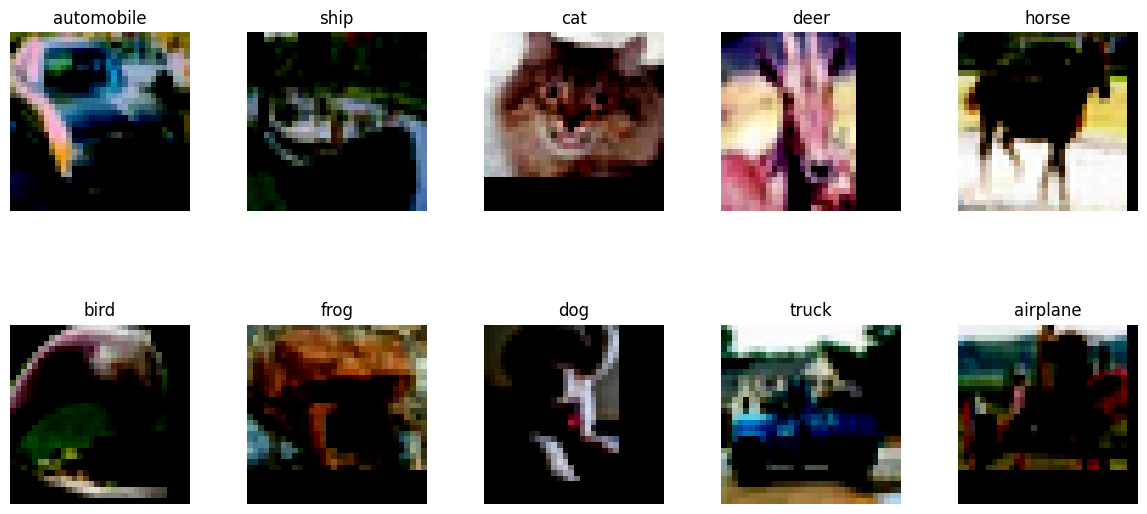

In [26]:
PrintImages(augmented_dataset_Standard)

Epoch [1/100], Loss: 1.7671, Train Accuracy: 33.66%, Test Accuracy: 37.16%
Epoch [2/100], Loss: 1.4918, Train Accuracy: 45.25%, Test Accuracy: 45.94%
Epoch [3/100], Loss: 1.3581, Train Accuracy: 50.61%, Test Accuracy: 49.30%
Epoch [4/100], Loss: 1.2678, Train Accuracy: 54.55%, Test Accuracy: 54.59%
Epoch [5/100], Loss: 1.2006, Train Accuracy: 57.18%, Test Accuracy: 51.82%
Epoch [6/100], Loss: 1.1465, Train Accuracy: 59.19%, Test Accuracy: 57.02%
Epoch [7/100], Loss: 1.1032, Train Accuracy: 60.77%, Test Accuracy: 57.34%
Epoch [8/100], Loss: 1.0507, Train Accuracy: 62.98%, Test Accuracy: 59.58%
Epoch [9/100], Loss: 1.0218, Train Accuracy: 63.41%, Test Accuracy: 54.33%
Epoch [10/100], Loss: 0.9812, Train Accuracy: 65.02%, Test Accuracy: 56.91%
Epoch [11/100], Loss: 0.9493, Train Accuracy: 66.48%, Test Accuracy: 56.61%
Epoch [12/100], Loss: 0.9032, Train Accuracy: 67.94%, Test Accuracy: 59.66%
Epoch [13/100], Loss: 0.8770, Train Accuracy: 68.65%, Test Accuracy: 54.57%
Epoch [14/100], Loss:

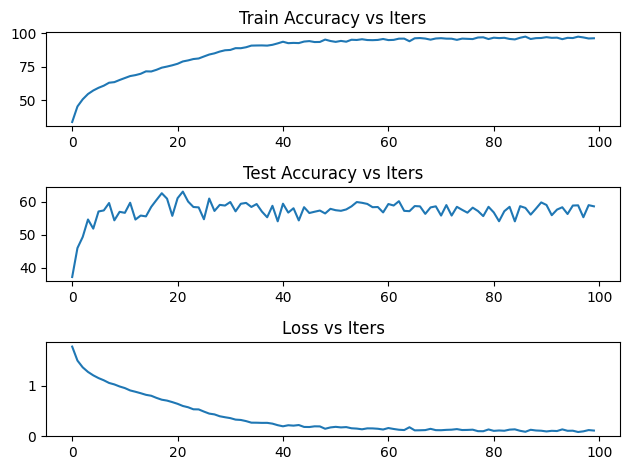

In [27]:
ModelRun(train_loader_Standard, test_loader, mixup=False, alpha=0)

# 5th Question

In [28]:
#Combine All
#Applying Standard Augmentaion on Train Image data

K = 4  # Shift range
cutout_prob = 0.5  # Probability of applying cutout
cutout_size = 16  # Size of the cutout mask

# Data Loaders
train_loader = torch.utils.data.DataLoader(subset_train_dataset, batch_size=batch_size, shuffle=True)

#Standard Augmentation
standard_dataset = Standard_dataset(train_loader)
standard_train_loader = torch.utils.data.DataLoader(standard_dataset, batch_size=batch_size, shuffle=True)
#CutOff Augmentation:
CutOff_dataset = CutOff_dataset(standard_train_loader)

Epoch [1/100], Loss: 1.9556, Train Accuracy: 29.20%, Test Accuracy: 36.80%
Epoch [2/100], Loss: 1.8121, Train Accuracy: 37.87%, Test Accuracy: 45.85%
Epoch [3/100], Loss: 1.7275, Train Accuracy: 42.85%, Test Accuracy: 47.32%
Epoch [4/100], Loss: 1.6477, Train Accuracy: 47.04%, Test Accuracy: 50.89%
Epoch [5/100], Loss: 1.6119, Train Accuracy: 48.49%, Test Accuracy: 52.55%
Epoch [6/100], Loss: 1.5649, Train Accuracy: 51.33%, Test Accuracy: 45.05%
Epoch [7/100], Loss: 1.5405, Train Accuracy: 52.45%, Test Accuracy: 58.07%
Epoch [8/100], Loss: 1.5077, Train Accuracy: 53.73%, Test Accuracy: 52.53%
Epoch [9/100], Loss: 1.4853, Train Accuracy: 55.88%, Test Accuracy: 57.37%
Epoch [10/100], Loss: 1.4606, Train Accuracy: 56.75%, Test Accuracy: 57.43%
Epoch [11/100], Loss: 1.4382, Train Accuracy: 57.25%, Test Accuracy: 53.59%
Epoch [12/100], Loss: 1.4203, Train Accuracy: 58.55%, Test Accuracy: 55.83%
Epoch [13/100], Loss: 1.4132, Train Accuracy: 59.47%, Test Accuracy: 58.39%
Epoch [14/100], Loss:

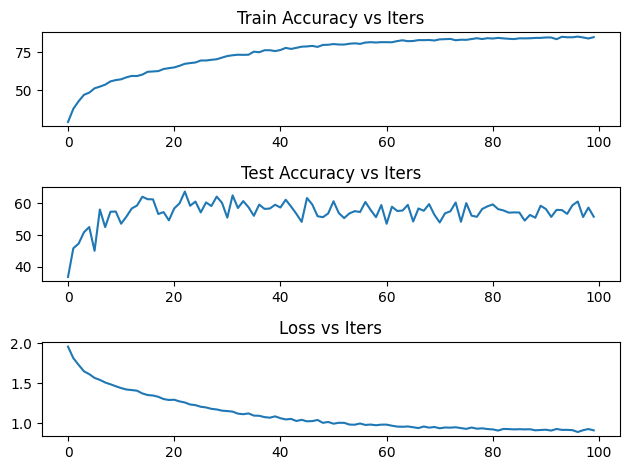

In [29]:
#Training Parameters
batch_size = 32
epochs = 100
learning_rate = 0.001
#Final Loaders
train_loader_combine = torch.utils.data.DataLoader(CutOff_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

ModelRun(train_loader_combine, test_loader, mixup=True, alpha=0.4) #Considering alpha as 0.4 as it's achieving higher accuracy

**Does combining improve things further?**
The Combined results acheived a highest Test accuracy of 63% as where as Non augmented is 62%. This shows that there isn't signficant increase in accuracy. And the reason is that we are transforming the input(original data) in every step, as a result the trained model when tested with test data couldn't find couldn't perform significantly better than the non augmented model.

# 6th Question 

**Data augmentation** plays a crucial role in improving the performance and generalization of deep learning models. It involves applying various transformations or modifications to the training data, such as above - mixup,cutoff, and Standard augmentation techniques, to create new synthetic training samples. These augmented samples introduce additional variations and diversity to the training set, allowing the model to learn more robust and invariant features.

**Effect on Test Accuracy**:
It helped to improve test accuracy by reducing overfitting. By augmenting the training data with diverse variations, the model becomes more capable of handling different variations and abnormalities in the test data. This enables the model to generalize better and achieve higher accuracy on unseen examples during the evaluation phase.

**Is test Accuracy Higher**: The test accuracy didn't increase significantly, the reason is as follows:
The non augmented Combine all (augmented) is acheivieng similar results. And the reason for not acheiving high accuracy is the way we are transforming the original data. Instead of combining the original data with augmented data we are transforming orginial data in every stage and then passing to the model. As a result we are acheiving similar results with and without augmentation.

**Effect on Train Accuracy**:
During training, data augmentation can lead to a slight decrease in train accuracy. This is because the augmented samples introduce more challenging variations that the model needs to learn and adapt to. As a result, the model may initially struggle to correctly classify the augmented training samples, leading to a lower train accuracy. However, with more epochs model acheived high training accuracy.

**Effect on Convergence of Optimization**:
Data augmentation can influence the convergence of optimization in a positive way. By providing a more diverse and extensive training set, data augmentation helps prevent overfitting and improves the model's ability to generalize well. With a larger and more varied training set, the optimization process encounters a wider range of examples, allowing the model to learn more representative and discriminative features. This, in turn, can lead to faster convergence and better optimization results.

**Does training loss converge faster**
Yes training loss converged faster for augmented data. This is because, it exposed the model to a larger and more diverse set of training examples.



# Extra Work

In [ ]:
#Combine all augmented data sets into one dataset and pass through the model (total 40,000 elements)
# Retrieve the tensors and labels from the datasets
subset_train_tensors = torch.stack([subset_train_dataset[i][0] for i in range(len(subset_train_dataset))])
subset_train_labels = [subset_train_dataset[i][1] for i in range(len(subset_train_dataset))]
subset_train_labels = [torch.tensor(label) for label in subset_train_labels]

augmented_tensors_2 = torch.stack([augmented_dataset_2[i][0] for i in range(len(augmented_dataset_2))])
augmented_labels_2 = [augmented_dataset_2[i][1] for i in range(len(augmented_dataset_2))]

augmented_CutOff_tensors = torch.stack([augmented_CutOff_dataset[i][0] for i in range(len(augmented_CutOff_dataset))])
augmented_CutOff_labels = [augmented_CutOff_dataset[i][1] for i in range(len(augmented_CutOff_dataset))]

augmented_tensors_Standard = torch.stack([augmented_dataset_Standard[i][0] for i in range(len(augmented_dataset_Standard))])
augmented_labels_Standard = [augmented_dataset_Standard[i][1] for i in range(len(augmented_dataset_Standard))]


In [ ]:
#Concate image tensors and label tensors
all_images_tensor = torch.cat((subset_train_tensors,augmented_tensors_2,augmented_CutOff_tensors,augmented_tensors_Standard), dim=0)        
Concat_label_list = subset_train_labels + augmented_labels_2 + augmented_CutOff_labels + augmented_labels_Standard
# print(Concat_label_list)
label_list_tensor = torch.stack(Concat_label_list, dim=0)
# print(all_images_tensor)

# Check dimensions and sizes
print("All images tensor shape:", all_images_tensor.shape)
print("Label list tensor shape:", label_list_tensor.shape)

#Transform to dataset
concatenated_dataset = torch.utils.data.TensorDataset(all_images_tensor, label_list_tensor)

In [ ]:
#Combine all
batch_size = 128
epochs = 100
learning_rate = 0.001

#Data Loaders
train_loader_combine = torch.utils.data.DataLoader(concatenated_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# ModelRun(train_loader_combine, test_loader)